# Brain Tumor Detection

### For Google Colab Users

In [ ]:
#@title ## Mount Your Google Drive & Map your Directory
#@markdown Please run this cell (`Ctrl+Enter` or `Shift+Enter`) and follow the steps printed bellow.
import os

from google.colab import drive
drive.mount('/content/gdrive')

# check Google Drive is mounted
if not os.path.isdir("/content/gdrive"):
  raise FileNotFoundError("Your Google Drive isn't mounted. Please run the above cell.")

assignment_dir = "/content/gdrive/MyDrive/workspace/BrainTumorDetection"  #@param{type:"string"}
assignment_dest = "/content/project"

# create symbolic link
!rm -f {assignment_dest}
!ln -s "{assignment_dir}" "{assignment_dest}"
print(f'Succesfully mapped (ln -s) "{assignment_dest}" -> "{assignment_dir}"')

# cd to linked dir
%cd -q {assignment_dest}
print(f'Succesfully changed directory (cd) to "{assignment_dest}"')

### Init

In [2]:
#@title ##Init

#@markdown Import required modules and observe your resources

# auto reload
%load_ext autoreload
%autoreload 2

# import
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
import wandb
wandb.login()

from experiment import Experiment
from post_process import get_masks_from_heatmaps
from data import DataGenerator, SegmentationGenerator

# Show resources
!nvidia-smi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Sat Jul 10 13:32:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  Off  | 00000000:0F:00.0 Off |                    0 |
| N/A   25C    P0    36W / 300W |      0MiB / 32508MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+


### Experiment

In [4]:
# params
config = {
"model_name": "vgg19_seg",
#"model_name": "vgg11",
#"data_train_class": DataGenerator,         "data_train_path": os.path.join(".", "Data", "Training"),
"data_train_class": SegmentationGenerator, "data_train_path": os.path.join(".", "SegmentationData", "train"),     "mri_type": "T1c", 
#"data_test_class": DataGenerator,          "data_test_path":  os.path.join(".", "Data", "Testing"),
"data_test_class": SegmentationGenerator,  "data_test_path":  os.path.join(".", "SegmentationData", "test"),      "mri_type": "T1c", 
"epochs": 8,
"train_batch_size": 100,
"lr": 1e-4,
"heatmap_batch_size": 256,
"occlusion_size": (60,60),
"heat_layers" : [['features', layer_num] for layer_num in [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34]] +
                [['classifier', -1]],
"heatmap_threshold" : 0.80,
"shuffle_data": True,
"device": "cuda"
}

with wandb.init(project="BrainTumorDetection", config=config):
    ### load best model
    experiment = Experiment(config)
    print("Model's accuracy: ", "{:.2f}".format(experiment.eval_model()), flush=True)
    #experiment.train_model()
    #print("Model's accuracy: ", "{:.2f}".format(experiment.eval_model()), flush=True)
    for image_num in [1, 3]:
        image_path = r"./Data/Testing/glioma_tumor/image({image_num}).jpg".format(image_num=image_num)
        ### generate heatmaps
        heatmaps = experiment.generate_heatmap(image_path)
        ### calculate masks
        hot_masks, cold_masks = get_masks_from_heatmaps(heatmaps, thresh=config["heatmap_threshold"], smallest_contour_len=30)

loading vgg19_seg model...
loading best model state from: ./Models/vgg19_seg.pth
Model's accuracy:  0.92
Creating heatmap...


100%|██████████| 256/256 [02:22<00:00,  1.79it/s]


Creating heatmap...


100%|██████████| 256/256 [02:22<00:00,  1.80it/s]


Test/accuracy/no,0.96667
_runtime,311
_timestamp,1625914121
_step,522
Test/accuracy/yes,0.86667
Test/accuracy,0.91667
memory/usage,1894.97705


Test/accuracy/no,▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Test/accuracy/yes,▁
Test/accuracy,▁
memory/usage,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


### Debug

In [48]:
# params
config = {
"model_name": "vgg19_seg",
#"model_name": "vgg11",
#"data_train_class": DataGenerator,         "data_train_path": os.path.join(".", "Data", "Training"),
"data_train_class": SegmentationGenerator, "data_train_path": os.path.join(".", "SegmentationData", "train"),     "mri_type": "T1c", 
"data_test_class": DataGenerator,          "data_test_path":  os.path.join(".", "Data", "Testing"),
#"data_test_class": SegmentationGenerator,  "data_test_path":  os.path.join(".", "SegmentationData", "test"),     "mri_type": "T1c", 
"epochs": 5,
"train_batch_size": 10,
"lr": 1e-4,
"heatmap_batch_size": 256,
"occlusion_size": (60,60),
"heat_layers" : [0, 2, 5, 7, 10, 12, 14, 16, 19, 21, 23, 25, 28, 30, 32, 34],
#"heat_layers" : [0, 3, 6, 8, 11, 13, 16, 18],
"heatmap_threshold" : 0.80,
"shuffle_data": True,
"device": "cuda"
}

def display(array):
    plt.figure()
    if len(array.shape) == 3:
        array = array.permute(1, 2, 0)
        plt.imshow(array)
    plt.imshow(array, cmap="gray")

wandb.init(project="BrainTumorDetection", config=config)
experiment = Experiment(config)
train_batch = next(iter(experiment.train_loader))
test_batch = next(iter(experiment.test_loader))
train_images, (train_gt, train_tumor_types) = train_batch
test_images, (test_gt, test_tumor_types) = test_batch

wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


loading vgg19_seg model...
loading best model state from: ./Models/vgg19_seg.pth


torch.Size([10, 3, 256, 256]) torch.float32
torch.Size([10, 256, 256]) torch.uint8
tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 0])
torch.Size([10, 3, 256, 256]) torch.float32
torch.Size([10]) torch.float64
tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1])


<ipython-input-48-4d84b7f45b34>:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


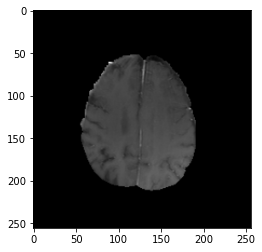

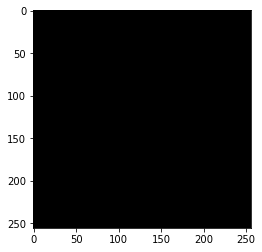

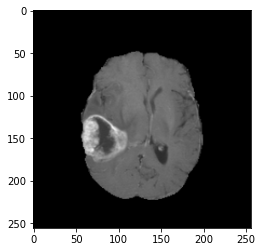

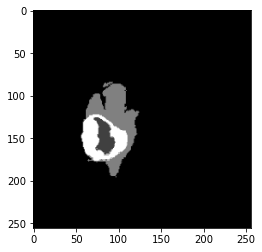

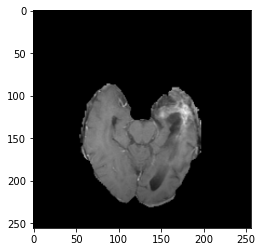

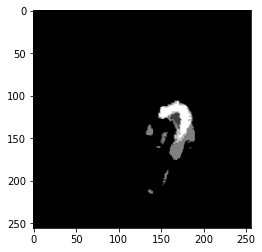

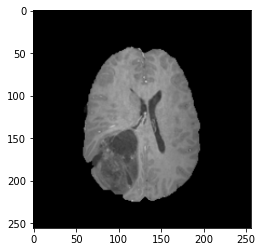

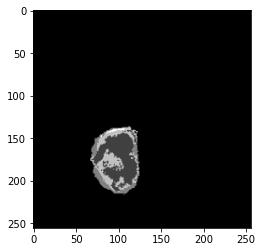

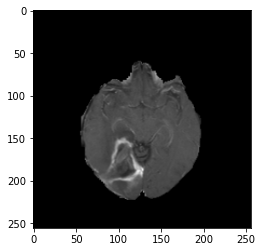

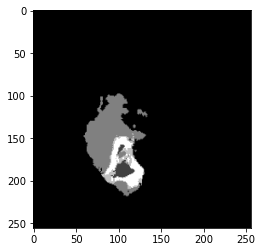

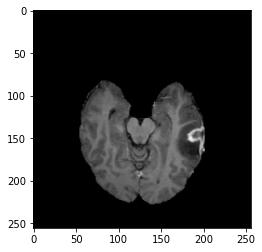

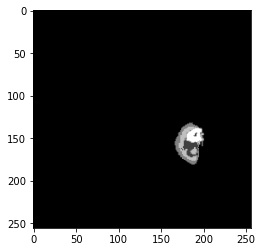

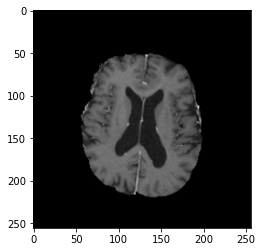

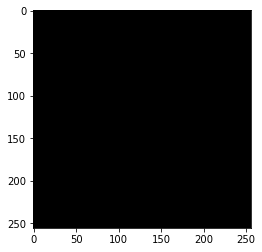

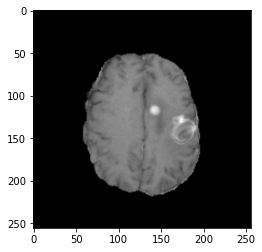

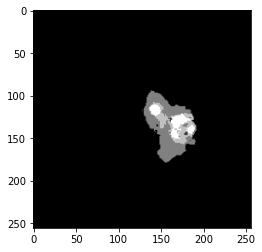

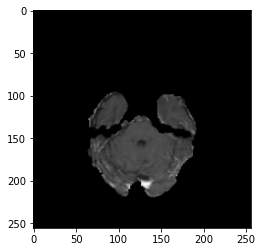

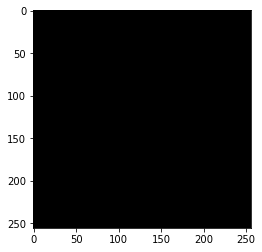

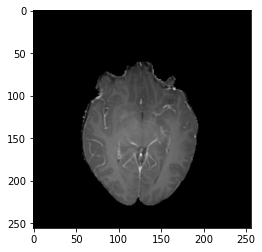

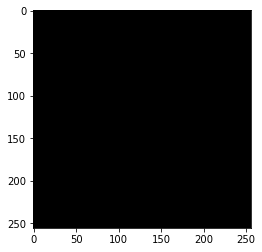

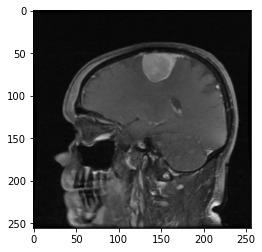

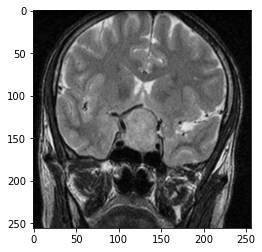

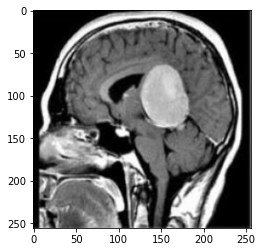

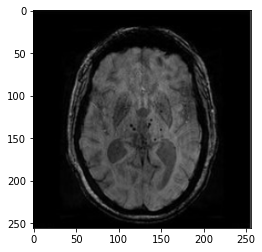

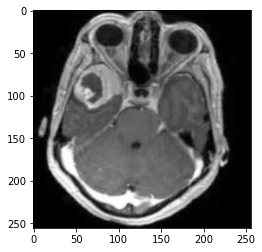

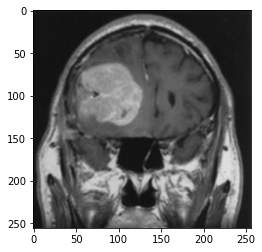

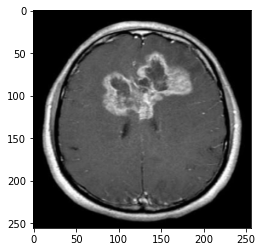

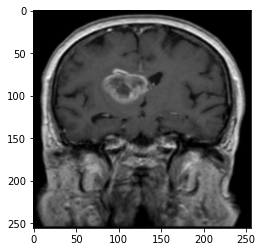

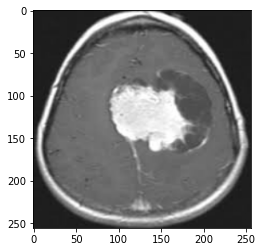

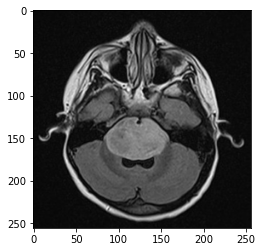

In [49]:
print(train_images.shape, train_images.dtype)
print(train_gt.shape, train_gt.dtype)
print(train_tumor_types)
print(test_images.shape, test_images.dtype)
print(test_gt.shape, test_gt.dtype)
print(test_tumor_types)

for i in range(train_images.size(0)):
    display(train_images[i])
    display(train_gt[i])
for i in range(test_images.size(0)):
    display(test_images[i])
    #display(test_gt[i].squeeze())
